<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/Notebooks/OC_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [580]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

## Reading the dataset from Google Drive


In [581]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')

tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", delimiter="\t",)

labels = te_data[:, 0]
print("Labels:", np.unique(labels))

Dataset: Earthquakes
Labels: [0. 1.]


## Splitting in Train-Test data

In [582]:
class_label = int(input('Positive class label: '))

train_data  = tr_data[tr_data[:, 0] == class_label, 1:] # train
test_data   = te_data[:, 1:]                            # test

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Positive class label: 0
Train data shape: (264, 512)
Test data shape: (139, 512)


## Labeling for OCC Task
<li> Label 1 for positive class </li>
<li> Label -1 for other class(es) </li>

In [583]:
occ_labels = [1 if x == class_label else -1 for x in labels]
print("Positive samples:", occ_labels.count(1))
print("Negative samples:", occ_labels.count(-1))

Positive samples: 104
Negative samples: 35


# MDS Plot 

In [584]:
embedding = MDS(n_components=2, random_state=42)
mds_data = embedding.fit_transform(train_data)
mds_test = embedding.fit_transform(test_data)
print(mds_data.shape)
print(mds_test.shape)

(264, 2)
(139, 2)


## Train

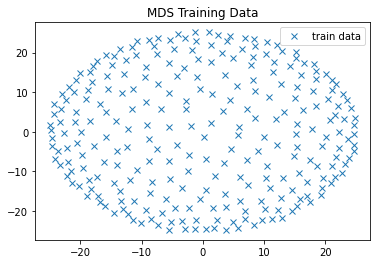

In [585]:
x = [row[0] for row in mds_data]
y = [row[1] for row in mds_data]

plt.plot(x, y, 'x',label='train data')
plt.title('MDS Training Data')
plt.legend()
plt.show()

## Test

In [586]:
negative_mds_test = np.array([x for x in mds_test[np.where(labels!=class_label)]])
positive_mds_test = np.array([x for x in mds_test[np.where(labels==class_label)]])

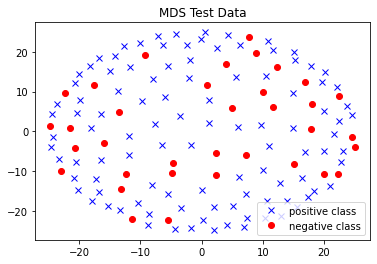

In [587]:
x_positive = [row[0] for row in positive_mds_test]
y_positive = [row[1] for row in positive_mds_test]

x_negative = [row[0] for row in negative_mds_test]
y_negative = [row[1] for row in negative_mds_test]

plt.plot(x_positive, y_positive, 'x', label='positive class', c = 'blue')
plt.plot(x_negative, y_negative, 'o', label='negative class', c = 'red')
plt.title('MDS Test Data')
plt.legend()
plt.show()

# Feature extraction


## PCA

In [588]:
"""pca = PCA(svd_solver='full')

train_data = pca.fit_transform(train_data)
test_data = pca.transform(test_data)
print(train_data.shape)"""

"pca = PCA(svd_solver='full')\n\ntrain_data = pca.fit_transform(train_data)\ntest_data = pca.transform(test_data)\nprint(train_data.shape)"

## Convolutional Autoencoder


In [589]:
# Convolutional Autoencoder with MaxPooling:
class ConvAutoencoder(tf.keras.Model):
    def __init__(self, serie_length):
        super(ConvAutoencoder, self).__init__()
        self.conv_1 = keras.layers.Conv1D(serie_length[0]//16, 3, activation='swish', padding='same', input_shape=(serie_length))
        self.max_1 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_2 = keras.layers.Conv1D(serie_length[0]//8, 3, activation='swish', padding='same')
        self.max_2 = keras.layers.MaxPooling1D(2, padding='same')
        self.conv_3 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
        
        # encoded representation
        self.encoded = keras.layers.MaxPooling1D(2, padding='same')
        
        # decoder layers
        self.conv_4 = keras.layers.Conv1D(1, 3, activation='swish', padding='same')
        self.up_1 = keras.layers.UpSampling1D(2)
        self.conv_5 = keras.layers.Conv1D(serie_length[0]//8, 3, activation='swish', padding='same')
        self.up_2 = keras.layers.UpSampling1D(2)
        self.conv_6 = keras.layers.Conv1D(serie_length[0], 3, activation='swish', padding='same')
        self.up_3 = keras.layers.UpSampling1D(2)
        
        # decoded output
        self.decoded = keras.layers.Conv1D(1, 3, activation='linear', padding='same')

    def encode(self, inputs):
        if self.padding != 0:
            inputs = keras.layers.ZeroPadding1D(padding=(8 + 8-self.padding, 0))(inputs)
        x = self.conv_1(inputs)
        x = self.max_1(x)
        x = self.conv_2(x)
        x = self.max_2(x)
        x = self.conv_3(x)
        return self.encoded(x)
    
    def call(self, inputs):
        self.padding = inputs.shape[1] % 8
        x = self.encode(inputs)
        x = self.conv_4(x)
        x = self.up_1(x)
        x = self.conv_5(x)
        x = self.up_2(x)
        x = self.conv_6(x)
        x = self.up_3(x)
        if self.padding != 0:
            x = keras.layers.Cropping1D(cropping=(8 + 8-self.padding, 0))(x)
        return self.decoded(x)
     
    def model(self):
        x = keras.layers.Input(shape=(serie_length, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

### Initializing and training the Conv Autoencoder

In [590]:
serie_length = train_data.shape[1]
model = ConvAutoencoder((serie_length, 1))

model.compile(optimizer='adam', loss='mse')

# Train
batch_size = 16
epochs = 50

train_data = train_data[..., np.newaxis]
test_data = test_data[..., np.newaxis]

model.fit(train_data, train_data, epochs=epochs, batch_size=batch_size)

Epoch 1/50
17/17 [==============================] - 2s 13ms/step - loss: 0.9567
Epoch 2/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8805
Epoch 3/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8680
Epoch 4/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8634
Epoch 5/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8613
Epoch 6/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8600
Epoch 7/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8593
Epoch 8/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8588
Epoch 9/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8584
Epoch 10/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8580
Epoch 11/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8578
Epoch 12/50
17/17 [==============================] - 0s 11ms/step - loss: 0.8576
Epoch 13/50
17/17 [==================

In [591]:
model.model().summary()

Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 512, 1)]          0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 512, 32)           128       
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 256, 32)           0         
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 256, 64)           6208      
_________________________________________________________________
max_pooling1d_121 (MaxPoolin (None, 128, 64)           0         
_________________________________________________________________
conv1d_282 (Conv1D)          (None, 128, 1)            193       
_________________________________________________________________
max_pooling1d_122 (MaxPoolin (None, 64, 1)             0  

# Results

## Data extracted by the ConvAutoencoder

### OC-SVM Fitting

In [592]:
train_data_encoded = np.array(model.encode(train_data))
train_data_encoded = np.squeeze(train_data_encoded)

clf_cae = OneClassSVM(gamma='scale', nu=0.2, kernel='rbf').fit(train_data_encoded)

### Scores

In [593]:
test_data_encoded = np.array(model.encode(test_data))
test_data_encoded = np.squeeze(test_data_encoded)

result_labels = clf_cae.predict(test_data_encoded)

acc = accuracy_score(occ_labels, result_labels)
precision = precision_score(occ_labels, result_labels)
recall = recall_score(occ_labels, result_labels)
f1 = f1_score(occ_labels, result_labels)

print("Accuracy: %.2f"  % (acc*100)       + "%")
print("Precision: %.2f" % (precision*100) + "%")
print("Recall: %.2f"    % (recall*100)    + "%")
print("F1-Score: %.2f"  % (f1*100)        + "%")

Accuracy: 64.75%
Precision: 75.23%
Recall: 78.85%
F1-Score: 77.00%


## Raw Data

### OC-SVM Fitting 

In [594]:
train_data_raw = np.squeeze(train_data)
clf = OneClassSVM(gamma='scale', nu=0.2, kernel='rbf').fit(train_data_raw)

### Scores

In [595]:
test_data_raw = np.squeeze(test_data)
result_labels = clf.predict(test_data_raw)

acc = accuracy_score(occ_labels, result_labels)
precision = precision_score(occ_labels, result_labels)
recall = recall_score(occ_labels, result_labels)
f1 = f1_score(occ_labels, result_labels)

print("Accuracy: %.2f"  % (acc*100)       + "%")
print("Precision: %.2f" % (precision*100) + "%")
print("Recall: %.2f"    % (recall*100)    + "%")
print("F1-Score: %.2f"  % (f1*100)        + "%")

Accuracy: 25.18%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
